# 1. Dataset with number of posts on medium.com website


## Load the data

In [26]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

df = pd.read_csv('medium_posts.csv')
df['published_date'] = pd.to_datetime(df['published']).dt.date
df = df.drop(columns='published')

df_by_day = df['published_date'].value_counts().sort_index() # sum articles for each year
df_by_day = df_by_day.to_frame().reset_index()
df_by_day.rename(columns={"published_date": "y", "index": "ds"}, inplace=True) # rename columns using Prophet's convention
df_by_day

,ds,y
0,1970-01-01,2
1,1970-01-18,3
2,2003-09-14,1
3,2004-04-04,1
4,2004-04-16,1
...,...,...
1733,2017-06-23,421
1734,2017-06-24,277
1735,2017-06-25,253
1736,2017-06-26,207


Two rows are from 1970 - it's probably an error. Let's remove them and plot the data:

Text(0, 0.5, 'Number of posts')

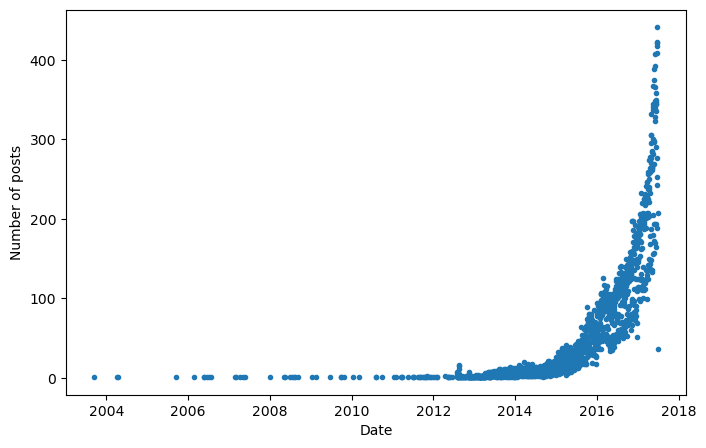

In [27]:
df_by_day = df_by_day.iloc[2:]
plt.figure(figsize=(8,5))
plt.plot(df_by_day['ds'], df_by_day['y'], '.')
plt.xlabel("Date")
plt.ylabel("Number of posts")

Until 2013 there are a lot of dates without number of posts. In these years Medium was probably very small website and using that thata can lead to unreliable predictions. I'll cut all rows to 01-01-2013.

Text(0, 0.5, 'Number of posts')

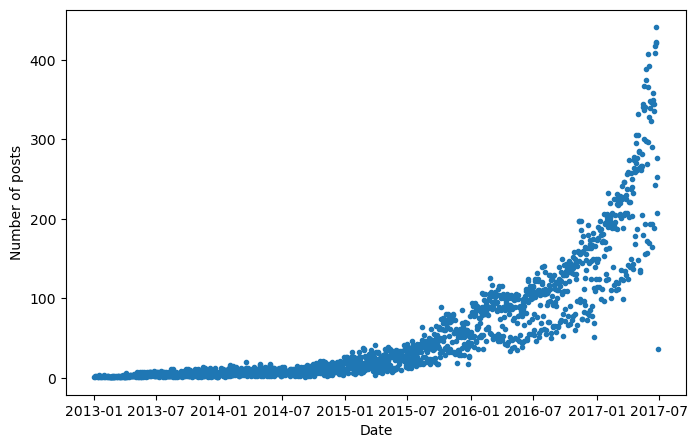

In [28]:
import datetime

cut_date = datetime.date(2013, 1, 1)
df_by_day = df_by_day[df_by_day.ds > cut_date]
plt.figure(figsize=(8,5))
plt.plot(df_by_day['ds'], df_by_day['y'], '.')
plt.xlabel("Date")
plt.ylabel("Number of posts")

# Prediction for standard parameters, forecast components:

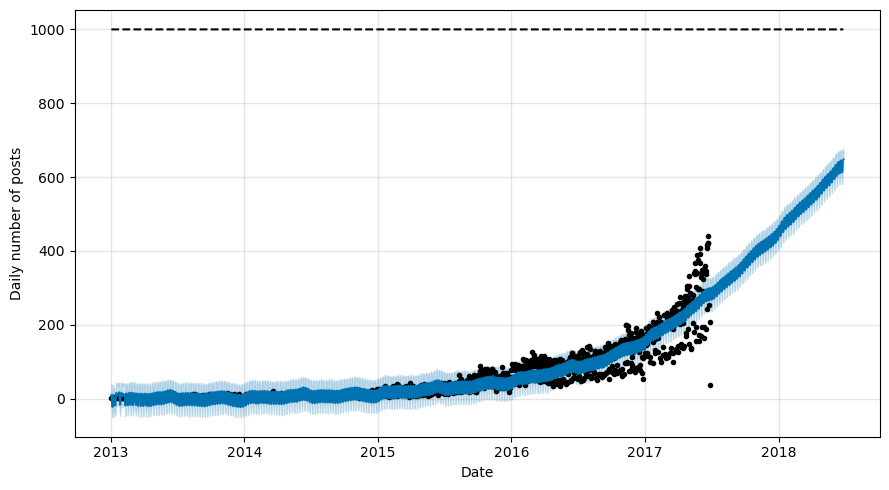

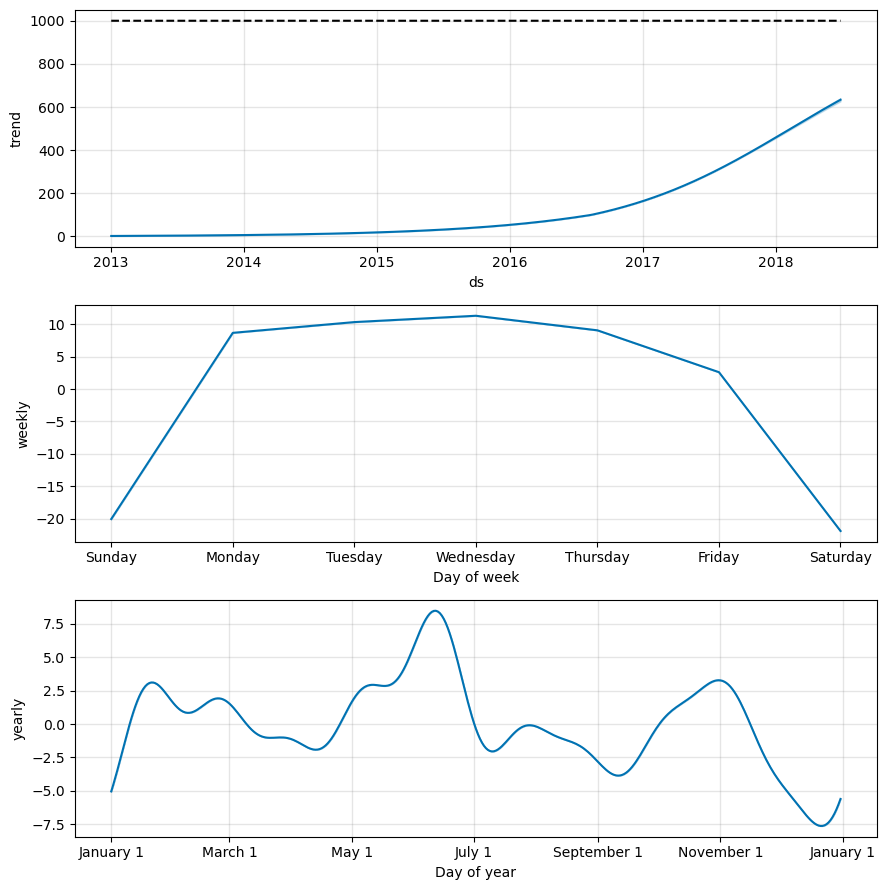

In [30]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
m = Prophet(growth='logistic')
df_by_day['cap'] = 1000
m.fit(df_by_day)
future = m.make_future_dataframe(periods=365)
future['cap'] = 1000
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(9, 5), xlabel='Date', ylabel='Daily number of posts')
fig2 = m.plot_components(forecast)

# Cross validation, metrics

  0%|          | 0/3 [00:00<?, ?it/s]

Mean MAE: 25.719122798589403
Mean MAPE: 29.287699249711096 %


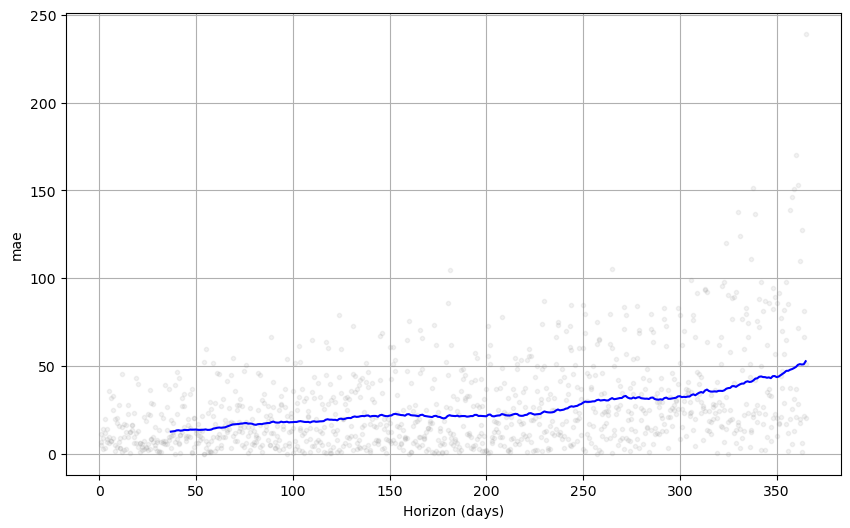

In [5]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import logging
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
df_cv = cross_validation(m, initial='730 days', period='182 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print("Mean MAE:", str(df_p['mae'].mean()))
print("Mean MAPE:", str(df_p['mape'].mean() * 100), '%')
fig = plot_cross_validation_metric(df_cv, metric='mae')

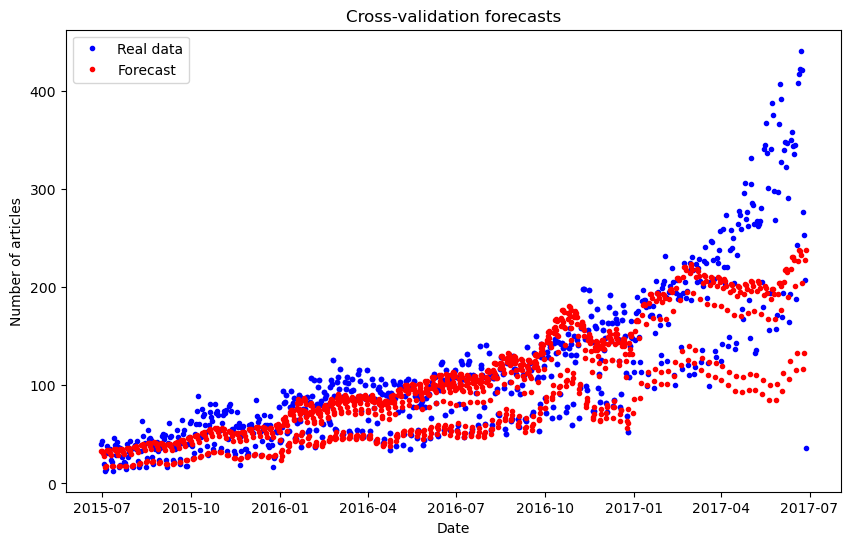

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_cv['ds'], df_cv['y'], 'b.', label='Real data')
ax.plot(df_cv['ds'], df_cv['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Number of articles')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts')

plt.show()

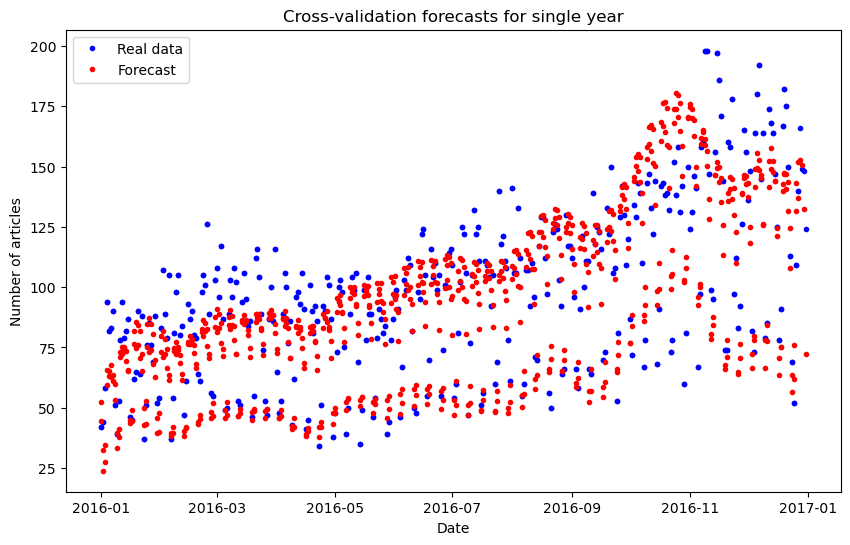

In [38]:
import numpy as np
lower_date = np.datetime64('2016-01-01')
upper_date = np.datetime64('2017-01-01')
year_forecast = df_cv[(df_cv.ds >= lower_date) & (df_cv.ds < upper_date)]


fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(year_forecast['ds'], year_forecast['y'], 'b.', label='Real data')
ax.plot(year_forecast['ds'], year_forecast['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Number of articles')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts for single year')

plt.show()

# Hyperparameters tuning

In [8]:
from common import *

import warnings
warnings.filterwarnings("ignore")

tune_optuna_logistic(df_by_day, 1000, save_study_name="medium-study-logistic-mape-shorter-cut", metric='mape')

[I 2023-03-12 12:08:40,182] A new study created in RDB with name: medium-study-logistic-mape-shorter-cut


Best trial:
   mape :  0.16693401279454115
  Params: 
    changepoint_prior_scale: 0.3758001747787103
    changepoint_range: 0.9318725689779309
    holidays_prior_scale: 0.017984952317648
    seasonality_mode: multiplicative
    seasonality_prior_scale: 0.029518181474767858


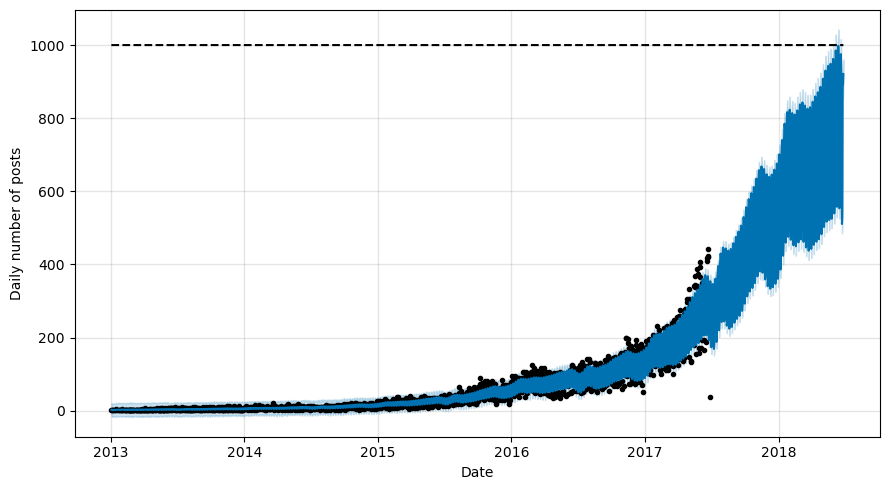

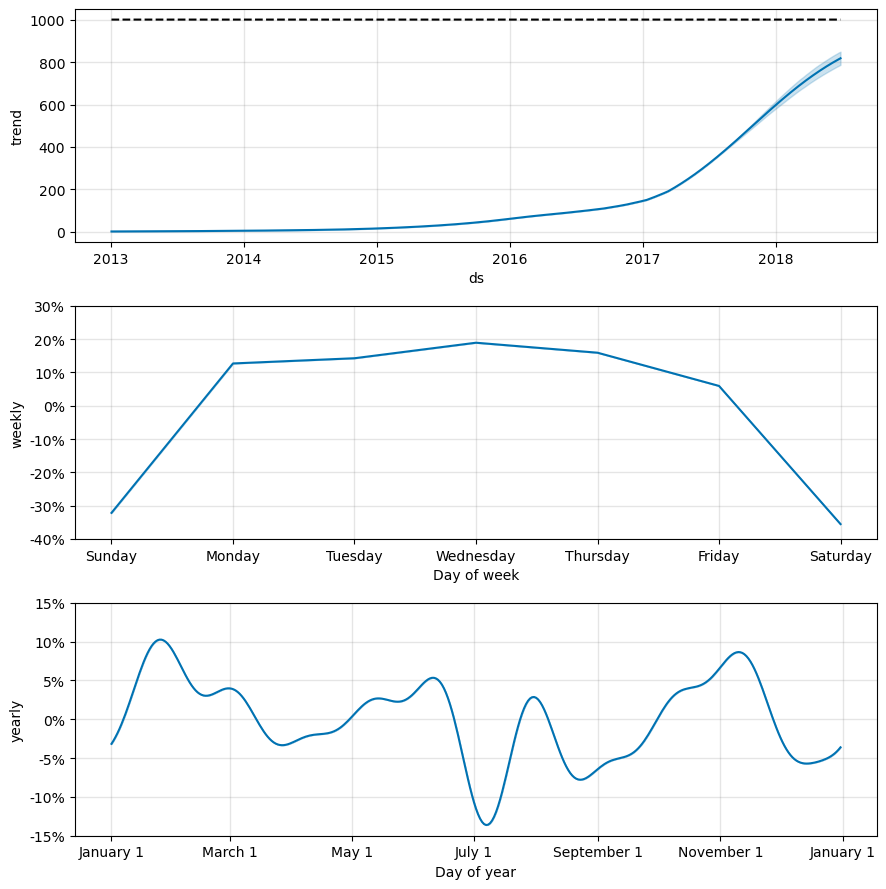

In [31]:
m = Prophet(changepoint_prior_scale=0.3758001747787103, changepoint_range=0.9318725689779309,
           holidays_prior_scale=0.017984952317648, seasonality_mode='multiplicative',
           seasonality_prior_scale=0.029518181474767858, growth='logistic')
m.fit(df_by_day)
future = m.make_future_dataframe(periods=365)
future['cap'] = 1000
forecast = m.predict(future)
fig1 = m.plot(forecast, figsize=(9, 5), xlabel='Date', ylabel='Daily number of posts')
fig2 = m.plot_components(forecast)

  0%|          | 0/3 [00:00<?, ?it/s]

Mean MAE: 18.458596128416353
Mean MAPE: 15.99771517901695 %


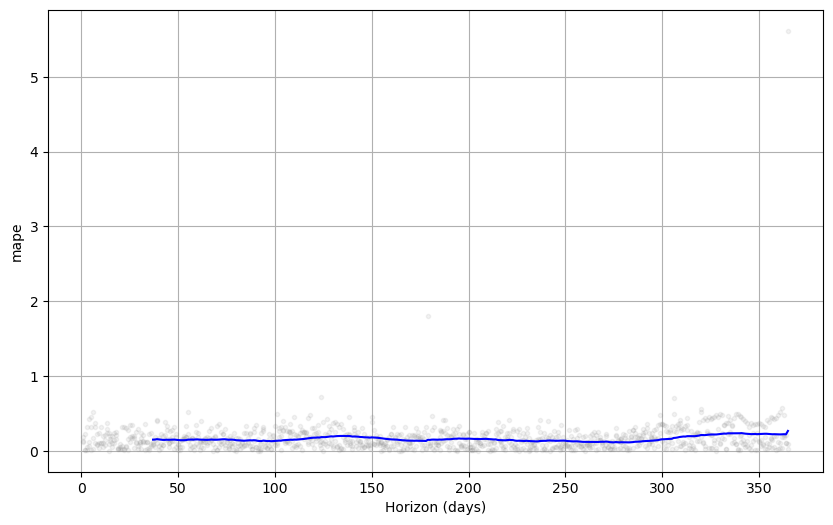

In [14]:
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
df_cv = cross_validation(m, initial='730 days', period='182 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print("Mean MAE:", str(df_p['mae'].mean()))
print("Mean MAPE:", str(df_p['mape'].mean()*100), '%')
fig = plot_cross_validation_metric(df_cv, metric='mape')

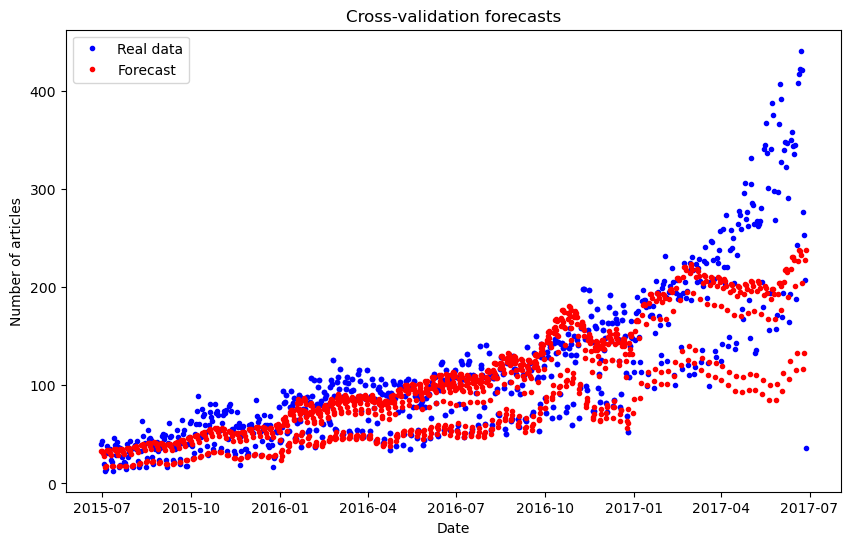

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_cv['ds'], df_cv['y'], 'b.', label='Real data')
ax.plot(df_cv['ds'], df_cv['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Number of articles')
ax.legend(loc='upper left')
ax.set_title('Cross-validation forecasts')
plt.show()

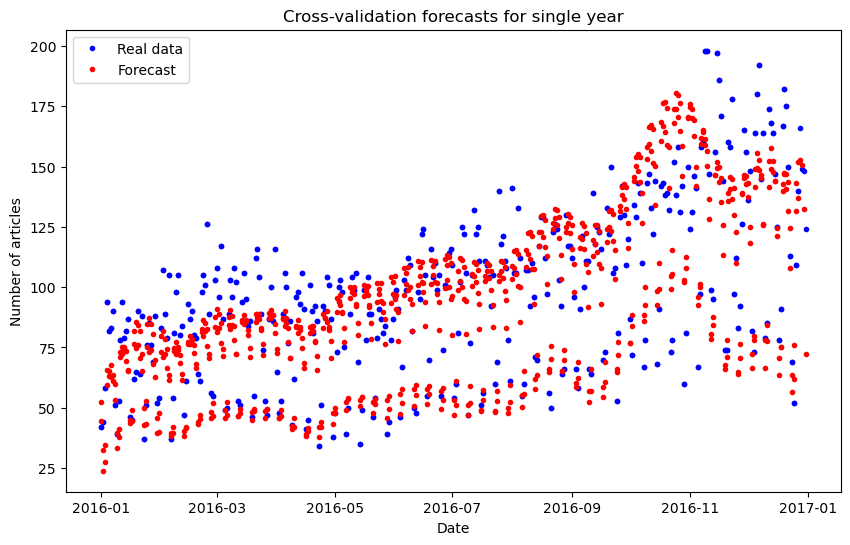

In [34]:
lower_date = np.datetime64('2016-01-01')
upper_date = np.datetime64('2017-01-01')
year_forecast = df_cv[(df_cv.ds >= lower_date) & (df_cv.ds < upper_date)]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(year_forecast['ds'], year_forecast['y'], 'b.', label='Real data')
ax.plot(year_forecast['ds'], year_forecast['yhat'], 'r.', label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Number of articles')
ax.set_title('Cross-validation forecasts for single year')
ax.legend(loc='upper left')

plt.show()